# [CS211A] Homework 2 by Aaron Beomjun Bae, Sakshi Agarwal
Student Number : 49967111, 57642896<br>
Student ID : beomjuna, sakshia1<br>
Due Date : 11:59pm Friday November 1st

In this homework assignment, we will try to answer the following parts in order:
1. Discrete Fourier Transform
2. Notch Filter
3. Analyzing DFT

## Part 1: Discrete Fourier Transform
### a) we follow the given steps to perform Discrete Fourier Transform on an image.
Step 1: Create a 512×512 pixel image.
<br><br>
Step 2: Assume that X and Y are the coordinates of pixels in the above image. Calculate the
value of each pixel using the following equation:
$$I(x,y)=\sin(0.2x)+\sin(0.3x)+\cos(0.4x)+\sin\Big(0.15\sqrt{x^2+y^2}\Big)+\sin\Big(0.35\sqrt{x^2+y^2}\Big)$$
Show your image in the pdf file. 

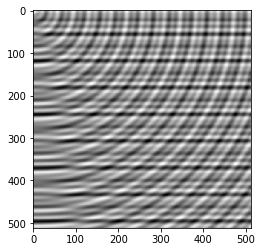

In [7]:
import matplotlib.pyplot as plt
import math
import numpy as np
import cv2
from scipy import signal

def generateEquationImage(x_pixels, y_pixels):
    newImage = np.zeros((x_pixels, y_pixels));
    # iterate row by column
    for i in range(len(newImage)):
        for j in range(len(newImage[i])):
            newImage[i,j] = math.sin(0.2*i) + math.sin(0.3*i) + math.cos(0.4*i); 
            newImage[i,j] += math.sin(0.15*math.sqrt(i**2+j**2));
            newImage[i,j] += math.sin(0.35*math.sqrt(i**2+j**2));        
    return newImage

# specify size
generated_image = generateEquationImage(512, 512);
plt.imshow(generated_image, cmap='gray');

Step3: Compute the Discrete Fourier Transform of this image. And show the magnitude and
phase of DFT for this image. You can use Matlab functions to calculate the DFT. You should
rearrange the final result to show the zero frequency in the center of the image. For this
purpose you can use “fftshift” function in Matlab.

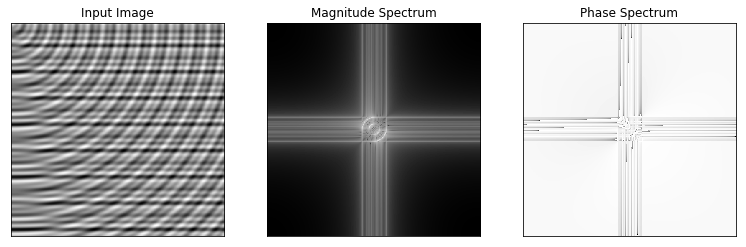

In [2]:
def displayImage(subplot_number, image, title):
    plt.subplot(subplot_number)
    plt.imshow(image, cmap = 'gray')
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    
def plot_dft(image, scale_factor=1, dont_show_plot=False):
    # Only when input is an image
    image = np.float32(image)
    
    # DFT and Shift to center
    dft = cv2.dft(image, flags = cv2.DFT_COMPLEX_OUTPUT) # note (.,.,2) shape due to complex
    dft_shifted = np.fft.fftshift(dft)
    dft_real = dft_shifted[:,:,0]
    dft_imaginary = dft_shifted[:,:,1]
    
    # Log-Scale to Visualize better
    magnitude_spectrum = np.log(cv2.magnitude(dft_real, dft_imaginary))
    phase = np.log(cv2.phase(dft_real, dft_imaginary))
    
    # Visualize
    if not dont_show_plot:
        plt.figure(figsize=(13*scale_factor, 13*scale_factor))
        displayImage(131, image, "Input Image")
        displayImage(132, magnitude_spectrum, "Magnitude Spectrum")
        displayImage(133, phase, "Phase Spectrum")
        plt.show()  
    
    # for step 4
    return dft_shifted

generated_dft = plot_dft(generated_image)

Step4: Multiply the magnitude of DFT with 2 and calculate the inverse Discrete Fourier Transform of it and show the result and explain the difference between the first image that you created in step 2 with this image.

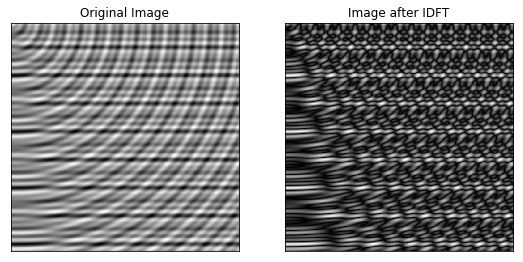

In [3]:
generated_dft = 2*generated_dft

def plot_idft(original_image, dft_shifted, scale_factor=1):
    # Shift to corner and IDFT 
    dft_ishifted = np.fft.ifftshift(dft_shifted)
    idft = cv2.idft(dft_ishifted)
    idft_real = idft[:,:,0]
    idft_imaginary = idft[:,:,1]
    image_reconstructed = cv2.magnitude(idft_real, idft_imaginary)
    
    # Visualize
    plt.figure(figsize=(9*scale_factor, 9*scale_factor))
    displayImage(121, original_image, "Original Image")
    displayImage(122, image_reconstructed, "Image after IDFT")

plot_idft(generated_image, generated_dft)

**A:** The phase of the two images remains the same and so the 'pattern' of the two images look similar. However, since we multiplied the dft with a scale factor of 2, both the real and imaginary part of the image in the time domain is also muliplied by 2. This property is homogeneity which means that a change in amplitude in one domain produces an identical change in amplitude in the other domain. The multiplication is essentially in the magnitudes of the frequencies of the sinusoids and hence, results in an equal multiplication in the spatial domain.

### b) Show the Discrete Fourier Transform of the following image and explain the pattern in the result in your pdf file.

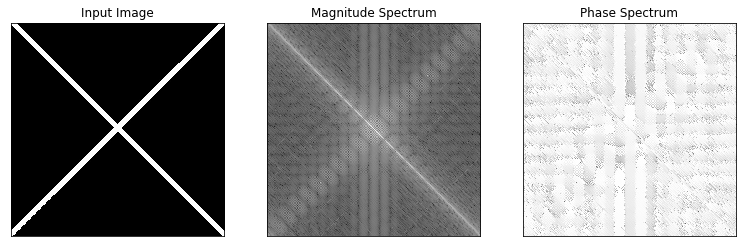

In [4]:
cross = cv2.imread('images/Cross.jpg',cv2.IMREAD_GRAYSCALE)
dft_shifted = plot_dft(cross)

**A:** The magnitude spectrum shows two diagonals intersecting at the centre of the plot. These lines are perpendicular to the two edges  in the original image. A strong line across an image will produce a perpendicular line in its FFT. Hence, we see two diagonal lines in the FFT. Every pixel of the Fourier image is a spatial frequency value, the magnitude of that value is encoded by the brightness of the pixel. We see that one of the diagonals in the FFT is brighter than the other, which means the magnitudes corresponding to those frequencies have a higher value. The phase plot shows the phase of the corresponding frequencies of the sinusoids in the image. We can see here that the brightness of the pixels are encoded by the phase of the frequency value and hence, notice a similar 'pattern' of brightness as in the magnitude spectrum denoting the fact that those frequencies have both magnitude as well as a phase component. 

## Part 2: Notch Filter
Use the following images from the image gallery and try to develop your own band-stop filter to remove the noise. For this purpose you should calculate the DFT of the image and remove a specific range of frequencies and then calculate the inverse DFT. You need to test different frequency intervals to find the best filter. (the final results might not be perfect but you should clearly see the noise reduce). Show the final result in the PDF file. 

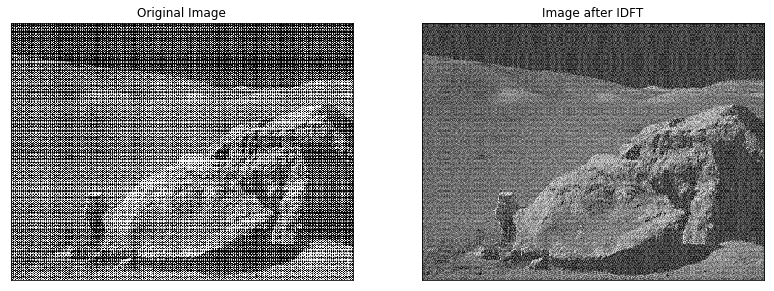

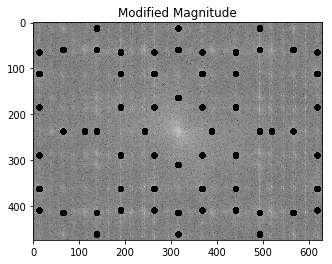

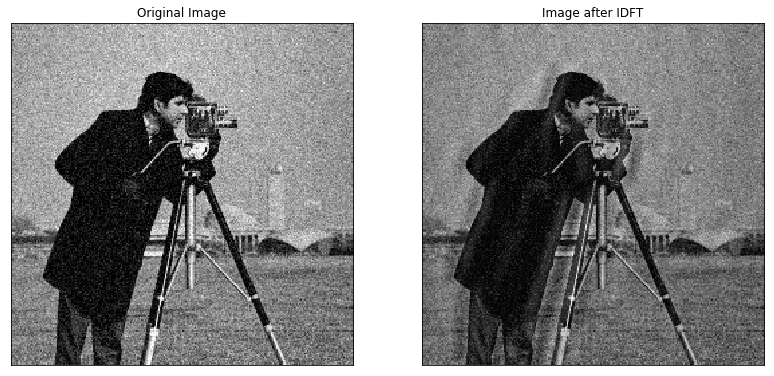

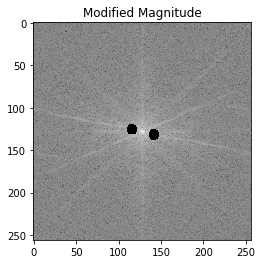

In [5]:
def getCircle(size):
    diameter = size if size % 2 ==1 else size + 1
    radius = diameter / 2
    x,y = np.ogrid[-radius:radius, -radius:radius]
    circle = x*x + y*y <= radius*radius
    return circle

def standard_notch(magnitude, safe_window, threshold_offset, radius):
    threshold = np.mean(magnitude) + threshold_offset
    center_x = int(len(magnitude)/2)
    center_y = int(len(magnitude[0])/2)
    
    # find target points
    target_x, target_y  = np.where(magnitude > threshold)
    indices_filter_x = np.logical_and(target_x > center_x-safe_window, target_x < center_x+safe_window) # removing safe_window points
    indices_filter_y = np.logical_and(target_y > center_y-safe_window, target_y < center_y+safe_window) # removing safe_window points
    final_index_filter = np.array(1 - np.logical_and(indices_filter_x, indices_filter_y), dtype=bool) # combining the safe_window filters
    target_x = target_x[final_index_filter] # applying the filter
    target_y = target_y[final_index_filter] # applying the filter
    
    #create a mask
    circle = getCircle(radius)
    mask = np.zeros(magnitude.shape)
    mask[target_x, target_y] = 1
    mask = signal.convolve2d(mask, circle, boundary='symm', mode='same')
    mask = 1 - mask
    mask = mask > 0 # when two targets are close, the values are < 0
    
    # apply the filter
    magnitude = magnitude * mask
    return magnitude
   
def plotNotchFilter(image_name, safe_window, threshold_offset, radius=15):
    # read image and DFT
    image = cv2.imread(image_name,cv2.IMREAD_GRAYSCALE)
    dft_shifted = plot_dft(image, 1.2, True)
    
    # create magnitude and phase
    dft_real = dft_shifted[:,:,0]
    dft_imaginary = dft_shifted[:,:,1]
    magnitude_spectrum = np.log(cv2.magnitude(dft_real, dft_imaginary))
    phase = np.log(cv2.phase(dft_real, dft_imaginary))
    
    # apply notch filter
    modified_magnitude = magnitude_spectrum[:,:]
    modified_magnitude = standard_notch(modified_magnitude, safe_window, threshold_offset, radius)
    
    # Bring DFT back from magnitude
    modified_dft_real = np.exp(modified_magnitude)*np.cos(np.exp(phase))
    modified_dft_imaginary = np.exp(modified_magnitude)*np.sin(np.exp(phase))
    modified_dft = np.stack((modified_dft_real, modified_dft_imaginary), axis=2)
    
    # IDFT
    plot_idft(image, modified_dft, 1.5)
    plt.figure();    
    plt.imshow(modified_magnitude, cmap="gray")
    plt.title("Modified Magnitude")
    
plotNotchFilter("images/moonlanding.png", safe_window=50, threshold_offset=4.3, radius=15);
plotNotchFilter("images/psnr2.png", safe_window=13, threshold_offset=3, radius=13);

## Part 3: Analyzing DFT
Choose a 64x64 image and find the Discrete Fourier Transform for the image. Now Add 64 columns and rows of zeros to the right and bottom side of the original image. Now find the DFT of this new image again. Repeat this process 2 more times each time doubling the image size and padding the pixels on the right and bottom by zeroes. You will therefore have 4 images – first one 64 x 64 with no zero padding and then 128x128, 256x256 and 512 x 512 after padding. Find the DFTs of all these images. Show all your results in the pdf file and explain the relationship between the four DFTs you get. Justify the relationship you discover.

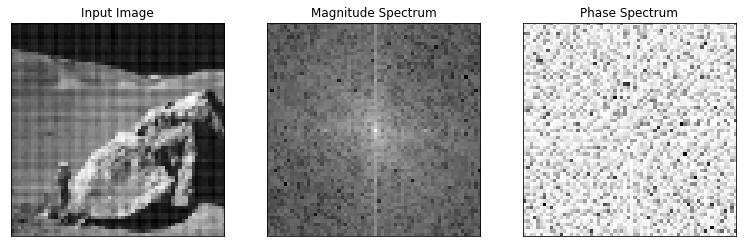

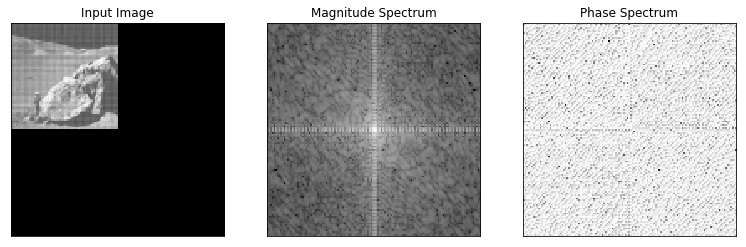

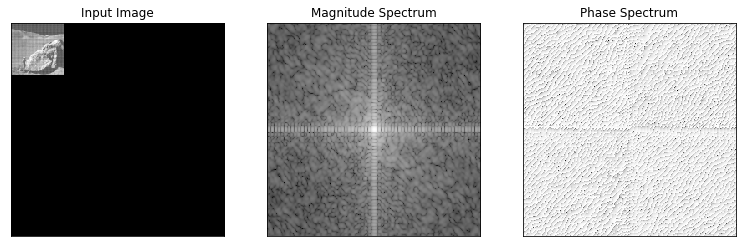

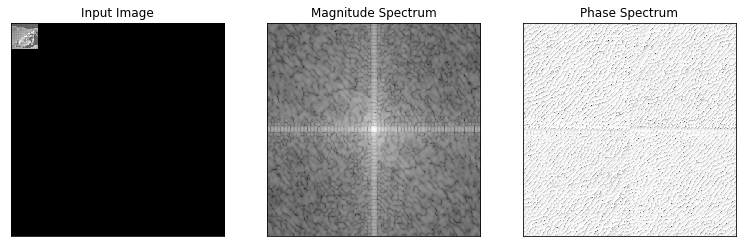

In [10]:
moonlanding = cv2.imread("images/moonlanding.png",cv2.IMREAD_GRAYSCALE)
moonlanding = cv2.resize(moonlanding, (64,64), interpolation = cv2.INTER_AREA)

for i in np.arange(4):
    dft = plot_dft(moonlanding)
    moonlanding = np.pad(moonlanding, (0, len(moonlanding)), 'constant', constant_values=(0,0))

**A:** We are zero padding the image, which is adding zeros to end of the image to increase its length. We also know that the distance between frequency bins Δf of the DFT output only depends on the length of the input sequence N and is given by -
Δf = 1/N

Hence, increasing the length of the input image affects the resolution of our frequency-domain output. There is not enough resolution in the frequency domain in the first image to see the energies at different frequencies. But as the length of the image increases, we see the resolution of the magnitude spectrum increases, to see the energies of different frequencies more clearly until the last image. Resolution we see is proportional to the length in the time domain.